In [1]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from CapsLayer import Capsule,squash,margin_loss,safe_norm,bridge
import json
tf.reset_default_graph()

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")



Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
input_dim = [28,28]

X = tf.placeholder(shape=[None, input_dim[0],input_dim[1], 1], dtype=tf.float32, name="X")
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")


In [3]:
caps1_n_maps = 16
caps1_n_dims = 16

num_classes =10



In [4]:
conv1 = tf.layers.conv2d(X, name="conv1", filters = 256, 
                         kernel_size = 9,strides = 1,padding = "valid", activation = None)
conv2 = tf.layers.conv2d(conv1, name="conv2", filters = caps1_n_maps * caps1_n_dims,
                         kernel_size = 9,strides = 2, padding = "valid",activation = None)

caps1_n_caps = caps1_n_maps * conv2.get_shape().as_list()[1]  * conv2.get_shape().as_list()[2] 

print(conv2)

Tensor("conv2/BiasAdd:0", shape=(?, 6, 6, 256), dtype=float32)


In [5]:



caps2 = Capsule(num_caps=64, caps_dims=16, name="caps2")
caps3 = Capsule(num_caps=num_classes, caps_dims=16, name="caps3")
caps4 = Capsule(num_caps=num_classes, caps_dims=16, name="caps4")

caps1_bridge =bridge(conv2,caps1_n_caps,caps1_n_dims,caps2)

caps2_output = caps2.capsule(caps1_bridge,caps1_n_caps,caps1_n_dims,tf.shape(X)[0],init_sigma = 0.5)
caps2_bridge = caps2.bridge(caps2_output,caps3)

caps3_output = caps3.capsule(caps2_bridge,caps2.num_caps,caps2.caps_dims,tf.shape(X)[0],init_sigma = 0.5)
caps3_bridge = caps3.bridge(caps3_output,caps4)

caps4_output = caps4.capsule(caps3_bridge,caps3.num_caps,caps3.caps_dims,tf.shape(X)[0],init_sigma = 0.5)

output = caps4_output
output_caps = caps4


Tensor("caps2_W_tiled:0", shape=(?, 576, 64, 16, 16), dtype=float32)
Tensor("caps_bridge:0", shape=(?, 576, 64, 16, 1), dtype=float32)
Tensor("caps2_predicted:0", shape=(?, 576, 64, 16, 1), dtype=float32)
Tensor("caps2_routing_weights:0", shape=(?, 576, 64, 1, 1), dtype=float32)
Tensor("caps2_weighted_predictions:0", shape=(?, 576, 64, 16, 1), dtype=float32)
Tensor("caps2_weighted_sum:0", shape=(?, 1, 64, 16, 1), dtype=float32)
Tensor("caps2_caps_output_round_1/mul:0", shape=(?, 1, 64, 16, 1), dtype=float32)
Tensor("caps2_caps_output_round_1_tiled:0", shape=(?, 576, 64, 16, 1), dtype=float32)
Tensor("caps2_agreement:0", shape=(?, 576, 64, 1, 1), dtype=float32)
Tensor("caps2_weighted_predictions_round_2:0", shape=(?, 576, 64, 16, 1), dtype=float32)
Tensor("caps3_W_tiled:0", shape=(?, 64, 10, 16, 16), dtype=float32)
Tensor("caps2_bridge:0", shape=(?, 64, 10, 16, 1), dtype=float32)
Tensor("caps3_predicted:0", shape=(?, 64, 10, 16, 1), dtype=float32)
Tensor("caps3_routing_weights:0", shape

In [6]:
y_proba = safe_norm(output, axis=-2, name="y_proba")
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

In [7]:
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=num_classes,
                                 name="reconstructone_hotone_hotion_mask")
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, num_classes, 1, 1],
    name="reconstruction_mask_reshaped")

caps_output_masked = tf.multiply(
    output, reconstruction_mask_reshaped,
    name="caps_output_masked")


decoder_input = tf.reshape(caps_output_masked,
                           [-1, output_caps.num_caps * output_caps.caps_dims],
                           name="decoder_input")

In [8]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = input_dim[0] * input_dim[1]

with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_sum(squared_difference,
                                    name="reconstruction_loss")


In [10]:

alpha = 0.0005

loss = tf.add(margin_loss(output,num_classes,y), alpha * reconstruction_loss, name="loss")
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")


init = tf.global_variables_initializer()
saver = tf.train.Saver()

Tensor("absent_error:0", shape=(?, 10), dtype=float32)


In [12]:
print("Starting training MNIST")
n_epochs = 10
batch_size = 50

restore_checkpoint = True

n_iterations_per_epoch = mnist.train.num_examples // batch_size

n_iterations_validation = 100#mnist.train.num_examples // batch_size


best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        sess.run(init)
#    init.run()
    predicted = ""
    for epoch in range(n_epochs):

        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
           #sess.graph.get_tensor_by_name("caps4_raw_weights:0")
            _, loss_train,pred,real = sess.run(
                [training_op, loss,y_pred,y],
                feed_dict={X: X_batch.reshape([-1, input_dim[0], input_dim[1], 1]),
                           y: y_batch})
                           #mask_with_labels: True})
            if(iteration % 2 == 0):
                #print("test1 : ",test_1)
                #print("test2 : ",test_2)
                predicted = "  predicted : {}  real : {}".format(pred[0:5],real[0:5])
            print(("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}"+predicted).format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
               
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, input_dim[0], input_dim[1], 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Starting training MNIST
Epoch: 1  Val accuracy: 96.8800%  Loss: 0.482650 (improved)5 8 6 0 7]  real : [5 8 6 0 7]
Iteration: 2/1100 (0.2%)  Loss: 0.42756  predicted : [6 0 6 7 1]  real : [6 0 6 7 1]

KeyboardInterrupt: 

In [16]:

n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

INFO:tensorflow:Restoring parameters from ./my_capsule_network


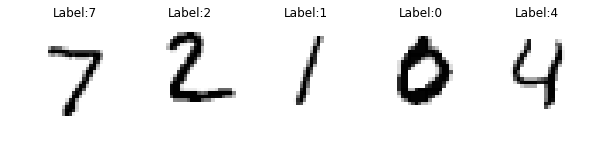

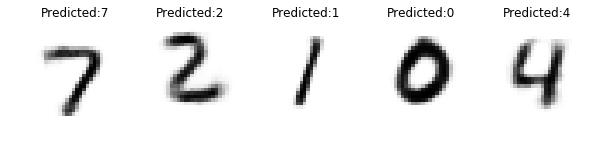

In [17]:
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()